# Overview  

This is an example notebook demonstrating some basic principles of building an ML model using a random forest classifier. It uses a dataset of mushrooms labeled as poisonous or edible.  The original dataset is located at https://www.kaggle.com/competitions/playground-series-s4e8/data?select=train.csv.  

The data dictionary for the dataset is provided below.

## Data Dictionary  

* __cap-diameter (m):__ float number in cm
* __cap-shape (n):__ bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
* __cap-surface (n):__ fibrous=i, grooves=g, scaly=y, smooth=s, dry=d, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
* __cap-color (n):__ brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
* __does-bruise-bleed (n):__ bruises-or-bleeding=t,no=f
* __gill-attachment (n):__ adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
* __gill-spacing (n):__ close=c, distant=d, none=f
* __gill-color (n):__ see cap-color + none=f
* __stem-height (m):__ float number in cm
* __stem-width (m):__ float number in mm
* __stem-root (n):__ bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
* __stem-surface (n):__ see cap-surface + none=f
* __stem-color (n):__ see cap-color + none=f
* __veil-type (n):__ partial=p, universal=u
* __veil-color (n):__ see cap-color + none=f
* __has-ring (n):__ ring=t, none=f
* __ring-type (n):__ cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
* __spore-print-color (n):__ see cap color
* __habitat (n):__ grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
* __season (n):__ spring=s, summer=u, autumn=a, winter=w

# Load libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc

# Clone full repo from Github
Note: If repo has previously been cloned, but you need to pull latest files, open a Terminal session and run `cd data-innovation-days-2025` to change to the repo directory, then run `git pull origin` to pull all files. Recommend then closing the Colab session and re-starting to ensure everything refreshes.


In [ ]:
if not os.path.exists('data-innovation-days-2025'):
  !git clone https://github.com/jeffjaylacs/data-innovation-days-2025.git
  print("Directory 'data-innovation-days-2025' created successfully.")
else:
  print("Directory 'data-innovation-days-2025' already exists. Skipping clone.")

# Read and preview data

In [ ]:
df = pd.read_csv('data-innovation-days-2025/data/train_subset.csv')
print("The original data contains the following number of rows and columns: ", (df.shape))

# Sample a percentage of the data frame to speed up model training times for this example notebook
df = df.sample(frac=0.25, random_state=42)  # random_state ensures reproducibility
display(df.head(10))

# Exploratory Data Analysis

## Univariate analysis

In [ ]:
# Univariate Analysis on the 'cap-diameter' column

# 1. Descriptive Statistics
print("\nDescriptive Statistics:")
print(df['cap-diameter'].describe())

# 2. Visualization: Histogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['cap-diameter'], bins=20, kde=True)
plt.title('cap-diameter Distribution')
plt.xlabel('cap-diameter')
plt.ylabel('Frequency')

# 3. Visualization: Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['cap-diameter'])
plt.title('Box Plot of cap-diameter')
plt.xlabel('cap-diameter')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Univariate Analysis on the 'gill-spacing' column

# 1. Fill missing values with a placeholder for visualization purposes
df['gill-spacing'] = df['gill-spacing'].fillna('Missing')

# 2. Frequency distribution
frequency_distribution = df['gill-spacing'].value_counts()
print("\nFrequency Distribution:")
print(frequency_distribution)

# 3. Descriptive statistics for categorical data
descriptive_stats = df['gill-spacing'].describe()
print("\nDescriptive Statistics:")
print(descriptive_stats)

# 4. Visualization: Bar Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gill-spacing',palette='deep')
plt.title('Count of gill-spacing')
plt.xlabel('gill-spacing')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Count missing values in each column
missing_values_count = df.isna().sum()

# Calculate the percentage of missing values in each column
missing_values_percent = (missing_values_count / len(df)) * 100

# Combine the results into a DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_values_count,
    'Missing Percentage': missing_values_percent
})

# Print the results
print("\nMissing Values Count and Percentage in Each Column:")
print(missing_summary)

In [ ]:
frequency_table = df['habitat'].value_counts()

print(frequency_table)

## Weight of Evidence  
WoE provides insights into the relationship between a predictor variable (i.e. a feature) and the target variable. It is frequently used in logistic regression for understanding how each bin relates to the target, but can be helpful as part of EDA for any type of classification model.  

`WOE = ln(%Non-event / %Event)` for any desired range of the predictor variable to be analyzed.

In [ ]:
# Calculate the total number of edible (good) and poisonous (bad) outcomes
total_edible = df['class'].value_counts().get('e', 0)
total_poisonous = df['class'].value_counts().get('p', 0)

# Calculate the distribution of target variable by category
woe_df = df.groupby('gill-spacing')['class'].value_counts().unstack(fill_value=0).reset_index()
woe_df.columns.name = None  # Remove the name of the index

# Rename columns for clarity
woe_df.columns = ['gill-spacing', 'edible', 'poisonous']

# Calculate the proportions
woe_df['edible_proportion'] = woe_df['edible'] / total_edible
woe_df['poisonous_proportion'] = woe_df['poisonous'] / total_poisonous

# Calculate WoE
woe_df['WoE'] = np.log(woe_df['edible_proportion'] / woe_df['poisonous_proportion'])

# Display the WoE DataFrame
print("\nWeight of Evidence DataFrame:")
print(woe_df[['gill-spacing', 'edible', 'poisonous', 'WoE']])

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(data=woe_df, x='gill-spacing', y='WoE', palette='pastel')
plt.title('Weight of Evidence by gill-spacing')
plt.xlabel('gill-spacing')
plt.ylabel('Weight of Evidence (WoE)')
plt.axhline(0, color='red', linestyle='--')  # Reference line at WoE = 0
plt.show()

# Feature Engineering

In [ ]:
# Create a new column 'stem-area' as the product of 'stem-height' and 'stem-width'
df['stem-area'] = df['stem-height'] * df['stem-width']

# Display the updated DataFrame with the new column
print("\nUpdated DataFrame with 'stem-area':")
display(df.head(10))

# Model Training

## Model data pre-processing  
Pre-processing your data so that it is compatible with common model algorithms is a bit different than the EDA exercise above.  While EDA is by definition "exporatory", the pre-processing step is not only conducted on the data during model training, but is then also required and replicated in production on new/live data to make that data suitable for generating predictions with the model.  The steps below get the data ready for model training.

### Target Definition  
Many classification model algorithms require the binary target to be represented by a 1 or 0.  We will call "poisonous" our positive class and represent it with a 1, and edible will be represented by a 0. Calling a poisonous mushroom the "positive" class sounds counter-intuitive, but that type of terminology is common (e.g. a patient test positive for a disease, or a customer defaults on a loan and "hits the target", etc.)

In [ ]:
df["class"] = df["class"].map({"e": 0, "p": 1})

frequency = df["class"].value_counts()
print(frequency)


### Remove features with no signal  
This dataset contains a column called "id" that indicates the row in the original dataset. The row number of an independent observation in the data should have no impact on the target variable. If it does, that is a type of data leakage.  For example, what if all the poisonous mushrooms were all listed first in the dataset?  Training on the model with "id" would simply be training the model to learn which rows the different types of mushrooms were in!

In [ ]:
df = df.drop(columns=['id'])

### Handling character/string columns  
Many python libraries used for training models require character/string columns to converted to numeric values.  There are 2 primary ways to accomplish this: One-hot encoding or indexing.

In [ ]:
# Step 1: Identify non-numeric columns excluding 'id' and 'class'
non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()
non_numeric_columns = [col for col in non_numeric_columns if col not in ['id', 'class']]

# Step 2: Identify columns that need indexing
indexed_features = ['season'] if 'season' in non_numeric_columns else []
non_numeric_columns.remove('season') if 'season' in non_numeric_columns else None

# Step 3: Create a mapping for the indexed feature (season) to numeric indices
season_mapping = {'s': 0, 'u': 1, 'a': 2, 'w': 3}
df['season_index'] = df['season'].map(season_mapping)
df.drop(columns=['season'], inplace=True)

# Step 4: Apply one-hot encoding to the remaining non-numeric columns
df_encoded = pd.get_dummies(df, columns=non_numeric_columns)

# Iterate through the columns of the encoded DataFrame and convert boolean columns to integers
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':  # Check if the column type is boolean
        df_encoded[col] = df_encoded[col].astype(int)


In [ ]:
column_names = df_encoded.columns.tolist()
print(column_names)

In [ ]:
display(df_encoded.head(10))


## Create train and test data sets  
Now that the data has been pre-processed, it is suitable for feeding into the modeling algorithm. The model will be built and tuned on the training data. The test data will be set completely off to the side and only used for final model performance evaluation.

In [ ]:
# Split the DataFrame.  random_state is a seed for reproducibility purposes.
train_df, test_df = train_test_split(df_encoded, test_size=0.3, random_state=42)

## Train the model

In [ ]:
# Features and target from train_df
X = train_df.drop(columns=["class"])
y = train_df["class"]

# Initialize the model with default hyperparameters
rf_model = RandomForestClassifier(max_depth=5)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean AUC:", cv_scores.mean())


In [ ]:
# Fit the RandomForestClassifier instance
rf_fit = rf_model.fit(X, y)

# Model Evaluation

## Test set performance

In [ ]:
# Separate features and target from test_df
X_test = test_df.drop(columns=['class'])
y_true = test_df['class']

# Generate predicted probabilities for the positive class
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Feature importance  
Examine the relative importance of the most impactful features in the model.

In [ ]:
# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df.head(15))

## Examine model parameters  
View (and eventually understand) all the parameters associated with the model object. Learn how they can be modified and/or optimized to best meet objectives of the model.

In [ ]:
# Print model information
print("Model Parameters:")
print(rf_model.get_params())

# Bonus Content!

Here is another model fitting example that runs a small hyper parameter optimization. It takes longer to run, because it is trying 10 random hyper-parameter combinations for each iteratation of the k-fold model training. It takes a while to execute, so we won't run it during the session, but try it on your own later.

In [191]:
rf_model_tuned = RandomForestClassifier(random_state=42)

# Define the hyperparameter space
param_dist = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model_tuned,
    param_distributions=param_dist,
    n_iter=7,  # number of random combinations to try
    cv=5,       # number of cross-validation folds
    scoring='roc_auc',
    random_state=42
)

# Fit the random search
random_search.fit(X, y)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate using cross_val_score
scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean AUC:", np.mean(scores))


Cross-validation scores: [0.995818   0.99716117 0.99626901 0.99563955 0.99621428]
Mean AUC: 0.9962203986768415


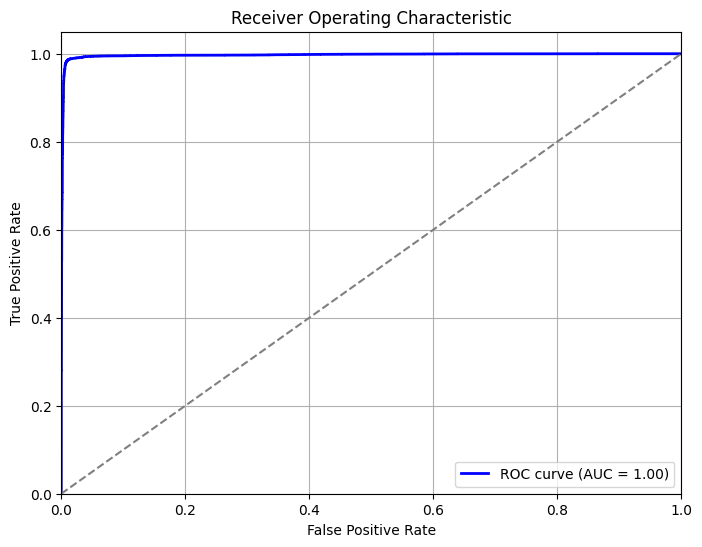

In [192]:
# Separate features and target from test_df
X_test = test_df.drop(columns=['class'])
y_true = test_df['class']

# Generate predicted probabilities for the positive class
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Further questions....  
1. Are these results realistic?
1. Is the model over-fit?
1. Is there data leakage?
1. Is this data set just really easy to train on?